In [77]:
import os
import pydicom
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

def perform_2d_wavelet_transform1(data, wavelet = 'db2'):
    coeffs = pywt.dwt2(data, wavelet=wavelet)
    return coeffs

def perform_3d_wavelet_transform_pywt(data, wavelet = 'db2'):
    coeffs = pywt.dwtn(data, wavelet=wavelet)
    return coeffs

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    if transform_type == '3D':
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2x4 grid
        keys = ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']  
        labels = {'LLL': 'LLL', 'LLH': 'LLH', 'LHL': 'LHL', 'LHH': 'LHH', 
                  'HLL': 'HLL', 'HLH': 'HLH', 'HHL': 'HHL', 'HHH': 'HHH'}
        for i, key in enumerate(keys):
            row, col = divmod(i, 4)
            if key in data:
                value = data[key]
                if value.ndim == 3:
                    value = value[0]  # Select the first slice if 3D
                value = normalize(value)  # Normalize the data
                axes[row, col].imshow(value, cmap='gray')
                axes[row, col].set_title(f'{title} - {labels[key]}')
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')  # Hide the axis if key is missing
    elif transform_type == '2D':
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1x4 grid
        keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
        labels = {'LL': 'LL', 'LH': 'LH', 'HL': 'HL', 'HH': 'HH'}
        for i, key in enumerate(keys):
            value = data[key]
            value = normalize(value)  # Normalize the data
            axes[i].imshow(value, cmap='gray')
            axes[i].set_title(f'{title} - {labels[key]}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_data = read_dicom_files(dicom_directory)



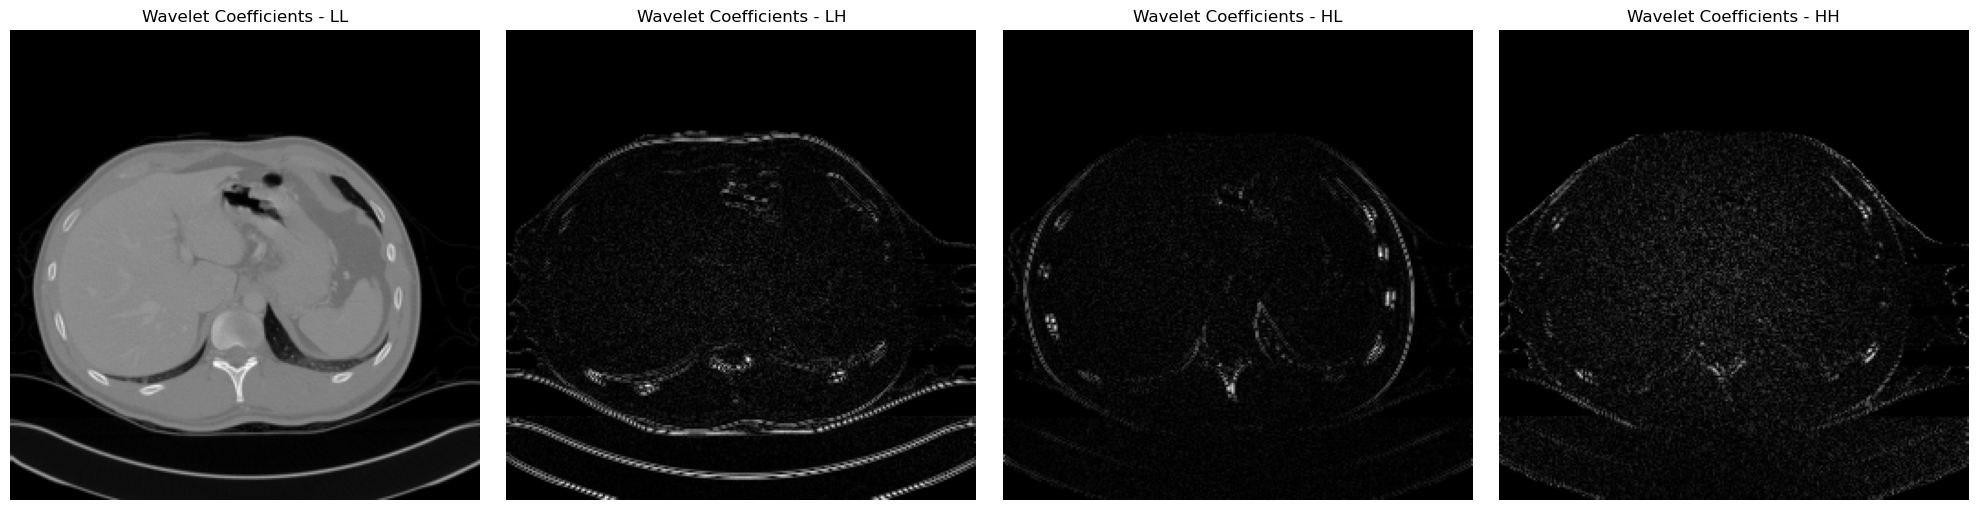

Subband LL resolution: (257, 257)
Subband LH resolution: (257, 257)
Subband HL resolution: (257, 257)
Subband HH resolution: (257, 257)


In [78]:
# Perform 2D wavelet transform
wavelet_coeffs_2d = perform_2d_wavelet_transform1(dicom_data[0])  # Use the first slice for 2D transform
display_images({'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}, 'Wavelet Coefficients', '2D')

# Print resolution of each subband
subbands = {'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}
for key, coeff in subbands.items():
    print(f"Subband {key} resolution: {coeff.shape}")

Original DICOM image resolution: (512, 512)
Approximation Coefficients resolution: (256, 256)
Horizontal Detail Coefficients resolution: (256, 256)
Vertical Detail Coefficients resolution: (256, 256)
Diagonal Detail Coefficients resolution: (256, 256)
MSE for LL subband: 2009282.9039040522
MSE for LH subband: 2177.357596883239
MSE for HL subband: 936.9300856257096
MSE for HH subband: 145.7673168008099


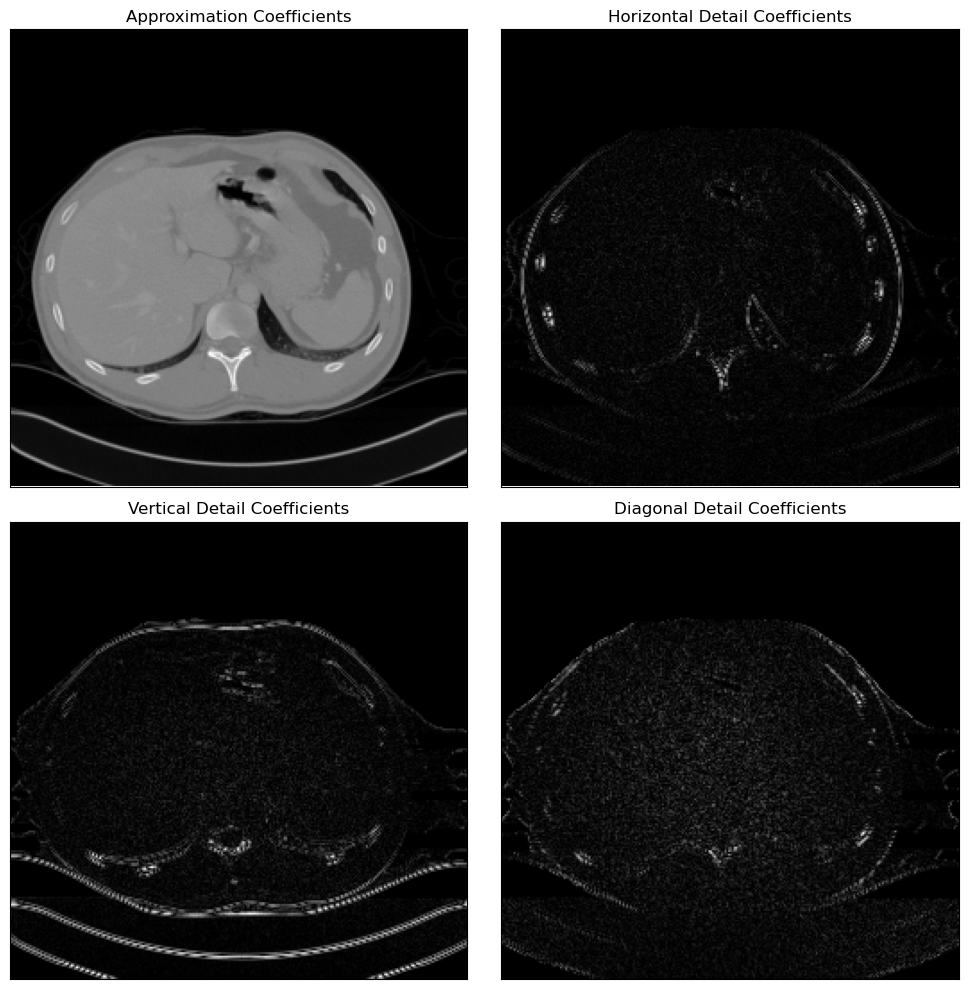

In [83]:
import os
import numpy as np
import pydicom
from scipy.signal import convolve2d
import pywt
import matplotlib.pyplot as plt

def read_dicom_files(directory):
    dicom_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom_files.append(pydicom.dcmread(filepath).pixel_array)
    return np.array(dicom_files)

# Define Daubechies 2 (db2) wavelet filters using PyWavelets coefficients
h = [-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416]
g = [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]

# Perform convolution with the filters and downsample
def wavelet_transform_2d(image, h, g):
    # Use symmetric padding
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='symmetric')
    
    # Convolve rows and columns, then downsample
    cA = convolve2d(padded_image, np.outer(h, h), mode='valid')[::2, ::2]
    cH = convolve2d(padded_image, np.outer(h, g), mode='valid')[::2, ::2]
    cV = convolve2d(padded_image, np.outer(g, h), mode='valid')[::2, ::2]
    cD = convolve2d(padded_image, np.outer(g, g), mode='valid')[::2, ::2]
    
    return cA, cH, cV, cD

# Crop the larger matrix to match the size of the smaller matrix
def crop_to_match(smaller, larger):
    return larger[:smaller.shape[0], :smaller.shape[1]]

# Directory containing the DICOM files
dicom_directory = 'Test_Sets/CT/3/DICOM_anon/'

# Read DICOM files
dicom_images = read_dicom_files(dicom_directory)

# Apply wavelet transform to the first DICOM image
image = dicom_images[0]

# Print the resolution of the original DICOM image
print(f"Original DICOM image resolution: {image.shape}")

cA, cH, cV, cD = wavelet_transform_2d(image, h, g)

# Print the resolution of the wavelet transform coefficients
print(f"Approximation Coefficients resolution: {cA.shape}")
print(f"Horizontal Detail Coefficients resolution: {cH.shape}")
print(f"Vertical Detail Coefficients resolution: {cV.shape}")
print(f"Diagonal Detail Coefficients resolution: {cD.shape}")

# Normalize each coefficient matrix
cA = np.abs(cA) / np.max(np.abs(cA))
cH = np.abs(cH) / np.max(np.abs(cH))
cV = np.abs(cV) / np.max(np.abs(cV))
cD = np.abs(cD) / np.max(np.abs(cD))

# Assuming perform_2d_wavelet_transform1 and display_images functions are defined
wavelet_coeffs_2d = perform_2d_wavelet_transform1(image)  # Use the first slice for 2D transform

# Compare subbands from each implementation
subbands_1 = {'LL': cA, 'LH': cH, 'HL': cV, 'HH': cD}
subbands_2 = {'LL': wavelet_coeffs_2d[0], 'LH': wavelet_coeffs_2d[1][0], 'HL': wavelet_coeffs_2d[1][1], 'HH': wavelet_coeffs_2d[1][2]}

# Calculate MSE for each subband
for key in subbands_1:
    if subbands_1[key].shape != subbands_2[key].shape:
        subbands_1[key] = crop_to_match(subbands_2[key], subbands_1[key])
        subbands_2[key] = crop_to_match(subbands_1[key], subbands_2[key])
    mse = np.mean((subbands_1[key] - subbands_2[key]) ** 2)
    print(f"MSE for {key} subband: {mse}")

# Display subbands
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(subbands_1['LL'], cmap='gray')
axes[0, 0].set_title('Approximation Coefficients')
axes[0, 1].imshow(subbands_1['LH'], cmap='gray')
axes[0, 1].set_title('Horizontal Detail Coefficients')
axes[1, 0].imshow(subbands_1['HL'], cmap='gray')
axes[1, 0].set_title('Vertical Detail Coefficients')
axes[1, 1].imshow(subbands_1['HH'], cmap='gray')
axes[1, 1].set_title('Diagonal Detail Coefficients')

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()